In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# project modules
import os
import sys
import re
sys.path.insert(0, os.path.abspath('../../modules'))

import helper_functions as hf


### Read the data

In [2]:
#balanced_dataset = '/../../data/training/ber-rating-dataset-final.csv' # final balanced dataset
balanced_dataset = '/../../data/training/ber-rating-dataset-final-split_0.csv' # 1st split of balanced dataset
balanced_dataset_1 = '/../../data/training/ber-rating-dataset-final-split_1.csv' # 1st split of balanced dataset
balanced_dataset_2 = '/../../data/training/ber-rating-dataset-final-split_2.csv' # 2nd split of balanced dataset
balanced_dataset_3 = '/../../data/training/ber-rating-dataset-final-split_3.csv' # 3rd split of balanced dataset

current_folder = os.path.abspath('.')

df = pd.read_table(current_folder + balanced_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="warn")
df_1 = pd.read_table(current_folder + balanced_dataset_1, sep=";", encoding='cp437', header=0, on_bad_lines="warn")
df_2 = pd.read_table(current_folder + balanced_dataset_2, sep=";", encoding='cp437', header=0, on_bad_lines="warn")
#df_3 = pd.read_table(current_folder + balanced_dataset_3, sep=";", encoding='cp437', header=0, on_bad_lines="warn")

df = pd.concat([df, df_2, df_1], ignore_index=True, sort=False)

# replace any spurious characters in feature names
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x))
# replace spaces in features names
df.columns = df.columns.str.strip().str.replace(" ", "").str.replace("[^\w]", "", regex=True)

print(df.shape)

df.head()


C:\Users\jbyrne\AppData\Local\Temp\ipykernel_1284\2277714451.py:10: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_table(current_folder + balanced_dataset_1, sep=";", encoding='cp437', header=0, on_bad_lines="warn")
C:\Users\jbyrne\AppData\Local\Temp\ipykernel_1284\2277714451.py:11: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_table(current_folder + balanced_dataset_2, sep=";", encoding='cp437', header=0, on_bad_lines="warn")


(82883, 212)


,index,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorAreasqm,UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
0,5640,Dublin 20,Semi-detached house,1969,Existing,F,403.64,116.82,1.96,0.65,...,NaN,NaN,268037012,0.050000,0.050000,0.000,46510.4,0.00,2.369,2.630
1,13237,Co. Meath,Detached house,1979,Existing,A3,63.37,167.87,0.17,0.13,...,NaN,NaN,167050001,0.050000,0.050000,0.481,18939.2,9863.61,0.711,0.403
2,14229,Co. Dublin,Semi-detached house,1986,Existing,B2,106.61,107.02,0.60,0.32,...,NaN,NaN,267134021,0.000222,0.012347,0.289,12788.9,4641.45,0.681,0.704
3,17232,Co. Wexford,Detached house,1880,Existing,D2,298.69,123.76,1.62,0.25,...,NaN,NaN,247109003/247109004,0.050000,0.050000,0.000,36220.3,0.00,2.046,1.683
4,17096,Co. Longford,Detached house,1982,Existing,C2,196.09,113.09,0.60,0.16,...,NaN,NaN,137045007,0.050000,0.050000,0.207,24747.5,5503.68,1.430,1.135


In [3]:
df['EnergyRating'].value_counts()
#df.loc[df['EnergyRating'] == "A2"]

EnergyRating
B1    5602
D2    5589
E2    5584
A3    5562
F     5557
G     5552
C1    5543
D1    5532
C3    5523
C2    5510
E1    5497
A2    5492
B2    5470
B3    5461
A1    5409
Name: count, dtype: int64

In [4]:
# Counting NaN values in all columns
nan_count = df.isna().sum()

drop_columns = []

for column, value in nan_count.items():
  if value/(len(df)) > 0.5:
    drop_columns.append(column)

print(drop_columns)

df_1 = df.drop(drop_columns, axis=1, inplace=False)

print(df_1.shape)
clean_df = df_1.dropna()
clean_df.shape

['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerProdComment', 'FirstEnerConsumedComment', 'SecondEnerProdComment', 'SecondEnerConsumedComment', 'ThirdEnerProdComment', 'ThirdEnerConsumedComment', 'FirstBoi

(12601, 147)

<Axes: ylabel='count'>

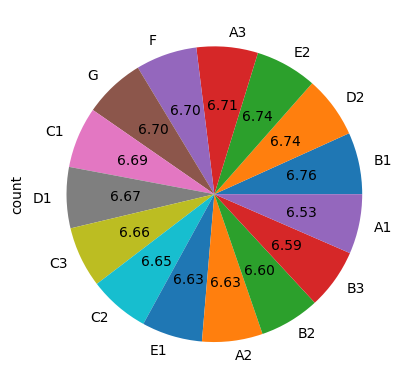

In [5]:
# check data to see if it is balanced
df['EnergyRating'].value_counts().plot.pie(autopct='%.2f')
#df.info(verbose=True, show_counts=True)

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['BerRating', 'EnergyRating'], axis='columns')
y_energy_rating = df[['EnergyRating']] # dependent variable
y_ber_rating = df[['BerRating']] 

X_train, X_test, y_energy_rating_train, y_energy_rating_test, y_ber_rating_train, y_ber_rating_test = train_test_split( X, y_energy_rating, y_ber_rating, test_size=0.2, shuffle=True,random_state=20)

X_train.shape, X_test.shape, y_energy_rating_train.shape, y_energy_rating_test.shape, y_ber_rating_train.shape, y_ber_rating_test.shape


((66306, 210), (16577, 210), (66306, 1), (16577, 1), (66306, 1), (16577, 1))

### Balance Dataset

In [7]:

# balance training data
X_train_merged = pd.concat([X_train, y_energy_rating_train], axis='columns')

X_train_res_merged, y_energy_rating_train_balanced = hf.feature_balance_data(X_train_merged, y_energy_rating_train)
X_train_balanced = X_train_res_merged.drop('EnergyRating', axis='columns')
y_energy_rating_train_balanced_2 = X_train_res_merged[['EnergyRating']]

# outputs - the total rows should be the same
[X_train_balanced.shape, y_energy_rating_train_balanced.shape, y_energy_rating_train_balanced_2.shape]

#print(type(X_train_merged))

all_vals: <class 'list'>
15
target_stats:  Counter({'G ': 4360, 'B1': 4360, 'C2': 4360, 'E1': 4360, 'C1': 4360, 'D1': 4360, 'A1': 4360, 'F ': 4360, 'C3': 4360, 'D2': 4360, 'E2': 4360, 'A2': 4360, 'A3': 4360, 'B2': 4360, 'B3': 4360})


[(65400, 210), (65400, 1), (65400, 1)]

In [8]:
# sum NaN's for each column
#for column_name in X_train_balanced:
#  print(X_train_balanced[column_name].isnull().sum())

<Axes: ylabel='count'>

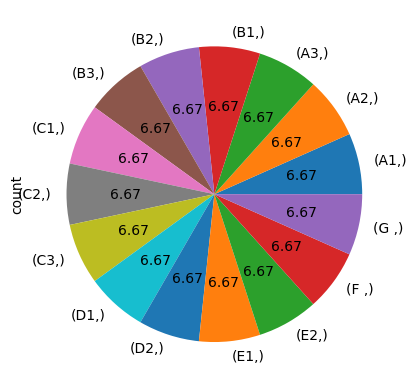

In [9]:
# check data to see if it is balanced
y_energy_rating_train_balanced.value_counts().plot.pie(autopct='%.2f')

### Pipeline for LightGBM

In [10]:
import datetime as dt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import lightgbm as lgb

# custom transformer classes
from tfidf_transformer import TfidfTransformer
from drop_features_transformer import DropFeaturesTransformerSingleton
from numerical_column_selector import NumericalColumnSelector
from categorical_column_selector import CategoricalColumnSelector
from save_feature_names_transformer import SaveFeatureNamesTransformerSingleton

from sklearn import set_config
#set_config(transform_output="pandas")

# various logging functions 

def features_logging(df):
    print('features_logging 1: ', type(df))
    if isinstance(df, pd.DataFrame):
        print('features_logging 2: ', df.columns.values.tolist())    
        #print(df.head())
    print('features_logging 3: ', df.shape)
    return df

def numerical_features_logging(df):
    print('numerical_features_logging 1: ', type(df))
    if isinstance(df, pd.DataFrame):
        numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
        print('numerical_features_logging 2: ', df[numerical_features].describe())    
        #print(df.head())
    print('numerical_features_logging 3: ', df.shape)
    return df

def features_logging_to_file(df):
    print('features_logging_to_file 1: ', type(df))
    print(df)
    print(df.shape)
    
    df_new = None

    if not isinstance(df, pd.DataFrame):
        # convert to dataframe
        features = SaveFeatureNamesTransformerSingleton().get_feature_names()
        print('features:', len(features))
        df_new = pd.DataFrame(df, columns=features)
        print(df_new.head())

    #print('features_logging_to_file 3: ', df.shape)
    if isinstance(df_new, pd.DataFrame):
        print('features_logging_to_file 4: dataframe - saving to file')
        curr_date_time = dt.datetime.now().strftime("%d%m%Y-%H%M%S")
        df_new.to_csv(current_folder + balanced_dataset + '_save_' + curr_date_time, sep=';', encoding='utf-8')
    else:
        print('features_logging_to_file 5: numpy array - can\'t save to file')
    return df

# Pipeline
#
# function transformers
clean_up_features_transformer = FunctionTransformer(hf.clean_up_features)
feature_main_heating_fuel_transformer = FunctionTransformer(hf.feature_main_heating_fuel)
feature_suspended_wooden_floor_transformer = FunctionTransformer(hf.feature_suspended_wooden_floor)
feature_ventilation_method_transformer = FunctionTransformer(hf.feature_ventilation_method)
features_convert_to_boolean = FunctionTransformer(hf.features_convert_to_boolean)
features_logging = FunctionTransformer(features_logging, feature_names_out='one-to-one')
numerical_features_logging = FunctionTransformer(numerical_features_logging, feature_names_out='one-to-one')
features_logging_to_file = FunctionTransformer(features_logging_to_file, feature_names_out='one-to-one')

# numeric processing pipeline
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
simple_imputer.set_output(transform='pandas')
min_max_scaler = MinMaxScaler()
min_max_scaler.set_output(transform='pandas')

numeric_processor = Pipeline(
    steps=[
            #('imputation_nan_to_zero', simple_imputer),
            ('Scaler', min_max_scaler),
            ('Numerical Feature Logging - n 2', numerical_features_logging),
            ('num_save_feature_names', SaveFeatureNamesTransformerSingleton(logging=True))  
            ])

# categorical processing pipeline
category_processor = Pipeline(
    steps=[
            ('feature_main_heating_fuel', feature_main_heating_fuel_transformer),
            ('feature_suspended_wooden_floor', feature_suspended_wooden_floor_transformer),
            ('feature_ventilation_method', feature_ventilation_method_transformer),
            ('features_convert_to_boolean', features_convert_to_boolean),
            ('feature_categorical_features_using_tf_idf', TfidfTransformer()),
            ('cat_save_feature_names', SaveFeatureNamesTransformerSingleton(logging=True))           
            ])

# determine categorical and numerical features
params_drop_features = {'logging': True}
dft_singleton = DropFeaturesTransformerSingleton(**params_drop_features)

# combining processing techniques
preprocessor = ColumnTransformer(
    [
        ('categorical', category_processor, CategoricalColumnSelector(drop_features_transformer_singleton=dft_singleton, logging=params_drop_features)), 
        ('numerical', numeric_processor, NumericalColumnSelector(drop_features_transformer_singleton=dft_singleton, logging=params_drop_features))
        ])

#num_leaves=108, learning_rate=0.15, max_depth=30, n_estimators=200, reg_alpha=1, reg_lambda=1
param_initial = {
        'metric': 'rmse',
        #'boosting': 'dart', 
        #'random_state': 48,
        'n_estimators': 200,
        'num_leaves': 108, 
        'learning_rate': 0.15, 
        'max_depth': 35, 
        #'bagging_freq': 1, 
        'feature_fraction': 0.9,
        #'min_gain_to_split': 1,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01
}

params_classifier = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "n_estimators": 200,
    "verbosity": -1,
    "bagging_freq": 1
}

pipe1 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('Feature Logging 3', features_logging),
            ('preprocessor', preprocessor),
            ('Feature Logging 4', features_logging_to_file),
            #('LightGBM', lgb.LGBMClassifier(**param_initial))
            ('LightGBM', lgb.LGBMClassifier())
            ])

SaveFeatureNamesTransformerSingleton constructor - self._feature_names length: 0
DropFeaturesTransformerSingleton constructor - self.features_to_drop length: 17


In [11]:
pipe1


Pipeline(steps=[('Clean up features',
                 FunctionTransformer(func=<function clean_up_features at 0x0000017E319D0FE0>)),
                ('Drop features', DropFeaturesTransformerSingleton()),
                ('Feature Logging 3',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function features_logging at 0x0000017E5E047600>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  P...
                                                                                       func=<function numerical_features_logging at 0x0000017E5E099760>)),
                                                                  ('num_save_feature_names',
                                                                   SaveFeatureNamesTransformerSingleton())]),
                                                  <numerical_column_selector.NumericalColumnSelector object at 0x0000017E35ADF990>)])),
                ('Feature Logging 4',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function features_logging_to_file at 0x0000017E5DF7A340>)),
                ('LightGBM', LGBMClassifier())])

### Baseline for LightGBM

In [12]:
# fit, predict, metrics
from sklearn.metrics import classification_report

print('X_train_balanced: ', type(X_train_balanced), X_train_balanced.shape)
print('y_energy_rating_train_balanced: ', type(y_energy_rating_train_balanced), y_energy_rating_train_balanced.shape)
print('X_test: ', type(X_test), X_test.shape)
print('y_energy_rating_test: ', type(y_energy_rating_test), y_energy_rating_test.shape)

pipe1.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score = pipe1.score(X_test, y_energy_rating_test)

y_preds = pipe1.predict(X_test)


X_train_balanced:  <class 'pandas.core.frame.DataFrame'> (65400, 210)
y_energy_rating_train_balanced:  <class 'pandas.core.frame.DataFrame'> (65400, 1)
X_test:  <class 'pandas.core.frame.DataFrame'> (16577, 210)
y_energy_rating_test:  <class 'pandas.core.frame.DataFrame'> (16577, 1)
DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Training
DropFeaturesTransformerSingleton - transform: dropping CountyName
DropFeaturesTransformerSingleton - transform: dropping TypeofRating
DropFeaturesTransformerSingleton - transform: dropping MultiDwellingMPRN
DropFeaturesTransformerSingleton - transform: dropping TGDLEdition
DropFeaturesTransformerSingleton - transform: dropping MPCDERValue
DropFeaturesTransformerSingleton - transform: dropping CPC
DropFeaturesTransformerSingleton - transform: dropping EPC
DropFeaturesTransformerSingleton - transform: dropping RER
DropFeaturesTransformerSingleton - transform: dropping RenewEPnren
DropFeaturesTransformerSingleton - transform: dro

In [13]:
# classification metrics
report = classification_report(y_energy_rating_test, y_preds)
print(report)

              precision    recall  f1-score   support

          A1       0.97      0.98      0.97      1049
          A2       0.94      0.89      0.91      1090
          A3       0.82      0.83      0.83      1109
          B1       0.71      0.74      0.73      1085
          B2       0.59      0.66      0.62      1076
          B3       0.54      0.54      0.54      1080
          C1       0.55      0.54      0.54      1150
          C2       0.50      0.40      0.45      1096
          C3       0.45      0.46      0.46      1121
          D1       0.47      0.45      0.46      1120
          D2       0.54      0.51      0.53      1151
          E1       0.54      0.57      0.55      1109
          E2       0.59      0.60      0.59      1132
          F        0.68      0.79      0.73      1087
          G        0.94      0.87      0.90      1122

    accuracy                           0.65     16577
   macro avg       0.66      0.66      0.65     16577
weighted avg       0.65   

### Baseline Classification Report

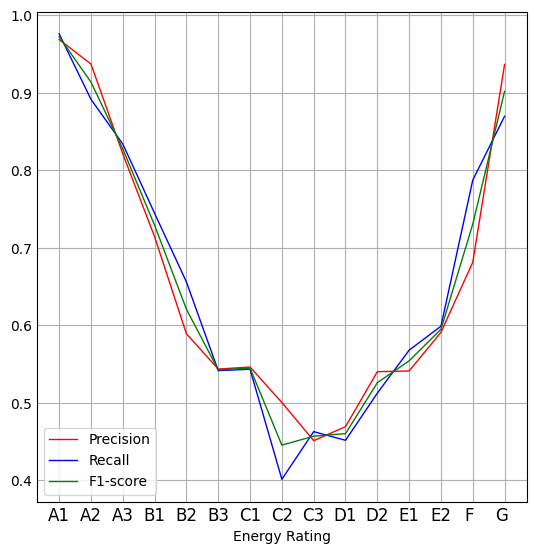

In [14]:
# reports
y_labels = sorted(y_energy_rating_test['EnergyRating'].unique())
x_len = len(y_labels)

# classification metrics
report = classification_report(y_energy_rating_test, y_preds, output_dict=True)

plt.style.use('_mpl-gallery')

# get data
x =  np.linspace(0, 1, x_len)
precision = []
recall = []
f1_score = []

for key in y_labels:
  precision.append(report[key]['precision'])
  recall.append(report[key]['recall'])
  f1_score.append(report[key]['f1-score'])

# plot
#cmap = plt.cm.coolwarm
fig_cr, ax_cr = plt.subplots(figsize=(5, 5))
ax_cr.plot(x, precision, color='red', label='Precision', linewidth=1.0)
ax_cr.plot(x, recall, color='blue', label='Recall', linewidth=1.0)
ax_cr.plot(x, f1_score, color='green', label='F1-score', linewidth=1.0)

# Set number of ticks for x-axis
ax_cr.set_xticks(x)
# Set ticks labels for x-axis
ax_cr.set_xticklabels(y_labels, rotation=0, fontsize=12)
ax_cr.set_xlabel('Energy Rating')
ax_cr.set_ylabel('')
plt.legend(loc='best')

plt.show()

### Baseline Confusion Matrix

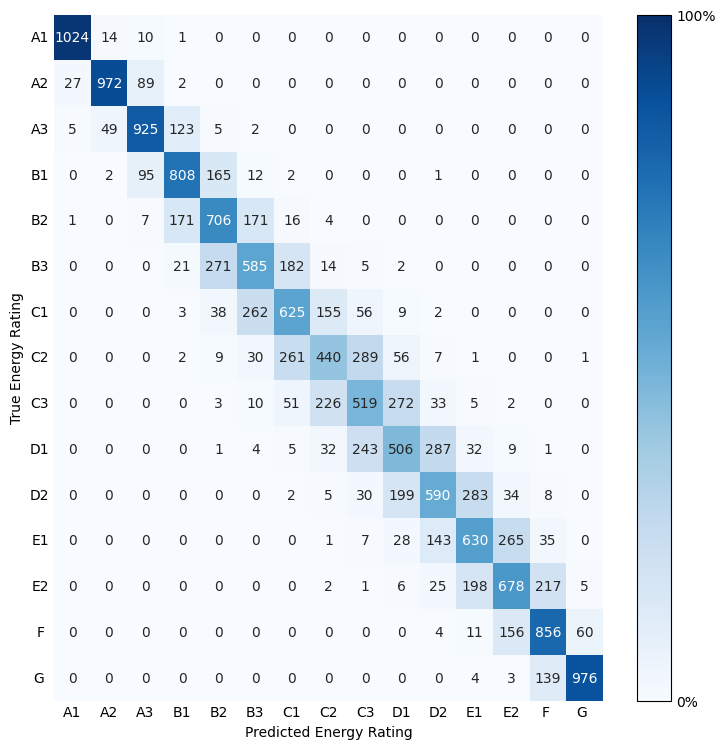

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_energy_rating_test, y_preds)

df_matrix = pd.DataFrame(cf_matrix, index=y_labels, columns=y_labels)
df_matrix_percent =  df_matrix.copy().apply(lambda x: (x/x.sum()), axis=1)

plt.figure(figsize=(7, 7))
#sns_matrix = sns.heatmap(df_matrix_percent, annot=True, cmap='Blues', fmt=f".0f", cbar=False, vmin=0, vmax=100) # annot_kws={"size": 35 / np.sqrt(len(df_matrix))}
sns_matrix = sns.heatmap(df_matrix_percent, annot=df_matrix, fmt=f".0f", cmap="Blues", cbar=False, vmin=0, vmax=1)

sns_matrix.set_yticklabels(sns_matrix.get_yticklabels(), rotation=0)
sns_matrix.set(xlabel="Predicted Energy Rating", ylabel="True Energy Rating")
cbar = sns_matrix.figure.colorbar(sns_matrix.collections[0])
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["0%", "100%"])
plt.show()

### Optuna for LightGBM

In [16]:
# optuna
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    
    global X_train_balanced, X_test, y_ber_rating_train_balanced, y_ber_rating_test

    # Define the parameter distributions for hyperparameter tuning
    # Using this guide: https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702
    # Parameter documentation: https://lightgbm.readthedocs.io/en/latest/Parameters.html

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "n_estimators": 500,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.003, 0.25, log=True), # Default is 0.1
        "num_leaves": trial.suggest_int("num_leaves", 8, 256), # Default is 31
        "max_depth": trial.suggest_int("max_depth", 10, 30),  # Default is -1
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 1, 100),  # Default is 20. AKA min_data_in_leaf.
        "subsample": trial.suggest_float("subsample", 0.5, 1.0), # Default is 1. AKA bagging_fraction.
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),  # Default is 1.0. AKA colsample_bytree.
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1),  # Default is 0. AKA lambda_l1.
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1)  # Default is 0. AKA lambda_l2.
    }

    pipe2 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            ('LightGBM', lgb.LGBMClassifier(**params))
            ])

    pipe2.set_params(LightGBM__stopping_rounds=20).fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel()).score(X_test, y_energy_rating_test)
    preds = pipe2.predict(X_test)
    accuracy = accuracy_score(y_energy_rating_test, preds)
    
    return accuracy

c:\Users\jbyrne\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(study_name="lightGBM", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-04-13 17:29:28,419] A new study created in memory with name: lightGBM


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 17:40:55,885] Trial 0 finished with value: 0.6732219340049466 and parameters: {'learning_rate': 0.018973390366445814, 'num_leaves': 187, 'max_depth': 10, 'min_data_in_leaf': 31, 'subsample': 0.5733779454085566, 'feature_fraction': 0.5461692973843989, 'reg_alpha': 0.1943976092638942, 'reg_lambda': 0.35210511977261727}. Best is trial 0 with value: 0.6732219340049466.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 17:56:29,756] Trial 1 finished with value: 0.6767810822223562 and parameters: {'learning_rate': 0.01734761040654581, 'num_leaves': 142, 'max_depth': 18, 'min_data_in_leaf': 69, 'subsample': 0.6022261248657588, 'feature_fraction': 0.9390587181954727, 'reg_alpha': 0.0371137172659469, 'reg_lambda': 0.6737628350766182}. Best is trial 1 with value: 0.6767810822223562.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 18:14:15,676] Trial 2 finished with value: 0.6928877360197865 and parameters: {'learning_rate': 0.018997136585326296, 'num_leaves': 147, 'max_depth': 12, 'min_data_in_leaf': 20, 'subsample': 0.9003722843377684, 'feature_fraction': 0.9841307878596988, 'reg_alpha': 0.3202899363776504, 'reg_lambda': 0.6953993895126209}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 18:25:02,597] Trial 3 finished with value: 0.6668878566688786 and parameters: {'learning_rate': 0.14471247597908832, 'num_leaves': 230, 'max_depth': 11, 'min_data_in_leaf': 4, 'subsample': 0.5849152097822845, 'feature_fraction': 0.9390712517147066, 'reg_alpha': 0.10736336549471959, 'reg_lambda': 0.42689654875500166}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 18:34:28,898] Trial 4 finished with value: 0.6781082222356277 and parameters: {'learning_rate': 0.2075168796376781, 'num_leaves': 140, 'max_depth': 24, 'min_data_in_leaf': 32, 'subsample': 0.8432504638407918, 'feature_fraction': 0.9173128359486864, 'reg_alpha': 0.02810539457074989, 'reg_lambda': 0.7526428717955178}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 18:38:28,880] Trial 5 finished with value: 0.6271339808167944 and parameters: {'learning_rate': 0.23798203799201087, 'num_leaves': 194, 'max_depth': 15, 'min_data_in_leaf': 79, 'subsample': 0.551613003288821, 'feature_fraction': 0.7239467630879526, 'reg_alpha': 0.9095095480621646, 'reg_lambda': 0.30067800688994273}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 18:42:52,719] Trial 6 finished with value: 0.6344935754358448 and parameters: {'learning_rate': 0.01071236894971911, 'num_leaves': 40, 'max_depth': 10, 'min_data_in_leaf': 68, 'subsample': 0.6058140580000295, 'feature_fraction': 0.6327733296861131, 'reg_alpha': 0.4966574276875349, 'reg_lambda': 0.06282891966590957}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 18:47:45,057] Trial 7 finished with value: 0.6845026241177535 and parameters: {'learning_rate': 0.038009934247071844, 'num_leaves': 44, 'max_depth': 22, 'min_data_in_leaf': 70, 'subsample': 0.5511672144139129, 'feature_fraction': 0.7070279939097841, 'reg_alpha': 0.6974561561504676, 'reg_lambda': 0.4200374768316336}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 18:56:59,340] Trial 8 finished with value: 0.626953007178621 and parameters: {'learning_rate': 0.0037417330112370765, 'num_leaves': 141, 'max_depth': 23, 'min_data_in_leaf': 52, 'subsample': 0.9722973779954067, 'feature_fraction': 0.7932775202509965, 'reg_alpha': 0.9043678961350047, 'reg_lambda': 0.14609995710477516}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 19:08:00,917] Trial 9 finished with value: 0.6518670447004886 and parameters: {'learning_rate': 0.005554511554181046, 'num_leaves': 209, 'max_depth': 18, 'min_data_in_leaf': 17, 'subsample': 0.963754290198017, 'feature_fraction': 0.6738829298727533, 'reg_alpha': 0.753303982104794, 'reg_lambda': 0.7287380054969469}. Best is trial 2 with value: 0.6928877360197865.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 19:15:42,852] Trial 10 finished with value: 0.6960849369608494 and parameters: {'learning_rate': 0.059223904085816535, 'num_leaves': 91, 'max_depth': 30, 'min_data_in_leaf': 99, 'subsample': 0.7859503048841812, 'feature_fraction': 0.8323364610397068, 'reg_alpha': 0.32775540054146657, 'reg_lambda': 0.9934564646405935}. Best is trial 10 with value: 0.6960849369608494.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 19:23:30,958] Trial 11 finished with value: 0.6987995415334499 and parameters: {'learning_rate': 0.058323047713704466, 'num_leaves': 87, 'max_depth': 30, 'min_data_in_leaf': 95, 'subsample': 0.7760892178389538, 'feature_fraction': 0.821630019321573, 'reg_alpha': 0.33939988078825145, 'reg_lambda': 0.9867037764310008}. Best is trial 11 with value: 0.6987995415334499.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 19:33:01,253] Trial 12 finished with value: 0.6934306569343066 and parameters: {'learning_rate': 0.06370546006501775, 'num_leaves': 85, 'max_depth': 30, 'min_data_in_leaf': 89, 'subsample': 0.7272378895280338, 'feature_fraction': 0.838876707414027, 'reg_alpha': 0.3863795030326116, 'reg_lambda': 0.9691004878001628}. Best is trial 11 with value: 0.6987995415334499.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 19:42:50,847] Trial 13 finished with value: 0.6883030705193943 and parameters: {'learning_rate': 0.07724484331308565, 'num_leaves': 90, 'max_depth': 30, 'min_data_in_leaf': 99, 'subsample': 0.7362484749795399, 'feature_fraction': 0.8190196514660516, 'reg_alpha': 0.28390074370166324, 'reg_lambda': 0.9967952662431866}. Best is trial 11 with value: 0.6987995415334499.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 19:50:38,235] Trial 14 finished with value: 0.6997044097243168 and parameters: {'learning_rate': 0.05281598396952281, 'num_leaves': 83, 'max_depth': 27, 'min_data_in_leaf': 99, 'subsample': 0.8192005973671506, 'feature_fraction': 0.8583868838117472, 'reg_alpha': 0.534982215734787, 'reg_lambda': 0.8688828361532135}. Best is trial 14 with value: 0.6997044097243168.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 19:54:37,415] Trial 15 finished with value: 0.6963262351450805 and parameters: {'learning_rate': 0.11226050217459266, 'num_leaves': 16, 'max_depth': 26, 'min_data_in_leaf': 84, 'subsample': 0.6845218330675567, 'feature_fraction': 0.8793395413942064, 'reg_alpha': 0.5753761802411066, 'reg_lambda': 0.852975916273148}. Best is trial 14 with value: 0.6997044097243168.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 20:01:33,011] Trial 16 finished with value: 0.7011521988297038 and parameters: {'learning_rate': 0.03515214381735083, 'num_leaves': 62, 'max_depth': 27, 'min_data_in_leaf': 55, 'subsample': 0.8219042888116954, 'feature_fraction': 0.7697251137188742, 'reg_alpha': 0.4880238029507553, 'reg_lambda': 0.8460743628478027}. Best is trial 16 with value: 0.7011521988297038.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 20:10:02,597] Trial 17 finished with value: 0.7006696024612414 and parameters: {'learning_rate': 0.0334799335062523, 'num_leaves': 59, 'max_depth': 26, 'min_data_in_leaf': 50, 'subsample': 0.8571251469569524, 'feature_fraction': 0.7642352189315574, 'reg_alpha': 0.5259015817411488, 'reg_lambda': 0.5744587157064143}. Best is trial 16 with value: 0.7011521988297038.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 20:19:09,212] Trial 18 finished with value: 0.7021777161126862 and parameters: {'learning_rate': 0.03410573899295629, 'num_leaves': 54, 'max_depth': 27, 'min_data_in_leaf': 51, 'subsample': 0.8891998558325775, 'feature_fraction': 0.7691624799152226, 'reg_alpha': 0.6692507299299204, 'reg_lambda': 0.576737436668179}. Best is trial 18 with value: 0.7021777161126862.


DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

[I 2024-04-13 20:29:08,067] Trial 19 finished with value: 0.5327260662363515 and parameters: {'learning_rate': 0.009368350712369886, 'num_leaves': 11, 'max_depth': 20, 'min_data_in_leaf': 56, 'subsample': 0.9196348708018088, 'feature_fraction': 0.6053046557469668, 'reg_alpha': 0.7061127633092648, 'reg_lambda': 0.5715989627386713}. Best is trial 18 with value: 0.7021777161126862.


Number of finished trials: 20
Best trial: {'learning_rate': 0.03410573899295629, 'num_leaves': 54, 'max_depth': 27, 'min_data_in_leaf': 51, 'subsample': 0.8891998558325775, 'feature_fraction': 0.7691624799152226, 'reg_alpha': 0.6692507299299204, 'reg_lambda': 0.576737436668179}


In [18]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_feature_fraction,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.673222,2024-04-13 17:29:28.422099,2024-04-13 17:40:55.882053,0 days 00:11:27.459954,0.546169,0.018973,10,31,187,0.194398,0.352105,0.573378,COMPLETE
1,1,0.676781,2024-04-13 17:40:55.886772,2024-04-13 17:56:29.755063,0 days 00:15:33.868291,0.939059,0.017348,18,69,142,0.037114,0.673763,0.602226,COMPLETE
2,2,0.692888,2024-04-13 17:56:29.759068,2024-04-13 18:14:15.676261,0 days 00:17:45.917193,0.984131,0.018997,12,20,147,0.320290,0.695399,0.900372,COMPLETE
3,3,0.666888,2024-04-13 18:14:15.677259,2024-04-13 18:25:02.596863,0 days 00:10:46.919604,0.939071,0.144712,11,4,230,0.107363,0.426897,0.584915,COMPLETE
4,4,0.678108,2024-04-13 18:25:02.599865,2024-04-13 18:34:28.897568,0 days 00:09:26.297703,0.917313,0.207517,24,32,140,0.028105,0.752643,0.843250,COMPLETE
5,5,0.627134,2024-04-13 18:34:28.899566,2024-04-13 18:38:28.880767,0 days 00:03:59.981201,0.723947,0.237982,15,79,194,0.909510,0.300678,0.551613,COMPLETE
6,6,0.634494,2024-04-13 18:38:28.882767,2024-04-13 18:42:52.718660,0 days 00:04:23.835893,0.632773,0.010712,10,68,40,0.496657,0.062829,0.605814,COMPLETE
7,7,0.684503,2024-04-13 18:42:52.721660,2024-04-13 18:47:45.056185,0 days 00:04:52.334525,0.707028,0.038010,22,70,44,0.697456,0.420037,0.551167,COMPLETE
8,8,0.626953,2024-04-13 18:47:45.058190,2024-04-13 18:56:59.340410,0 days 00:09:14.282220,0.793278,0.003742,23,52,141,0.904368,0.146100,0.972297,COMPLETE
9,9,0.651867,2024-04-13 18:56:59.342584,2024-04-13 19:08:00.916254,0 days 00:11:01.573670,0.673883,0.005555,18,17,209,0.753304,0.728738,0.963754,COMPLETE


In [19]:
print('Best hyperparameters:', study.best_params)
print('Best multi_logloss:', study.best_value)

Best hyperparameters: {'learning_rate': 0.03410573899295629, 'num_leaves': 54, 'max_depth': 27, 'min_data_in_leaf': 51, 'subsample': 0.8891998558325775, 'feature_fraction': 0.7691624799152226, 'reg_alpha': 0.6692507299299204, 'reg_lambda': 0.576737436668179}
Best multi_logloss: 0.7021777161126862


### Results for LightGBM Classifier using optimised parameters from Optuna

In [ ]:
# Best parms - copied from above
#best_params = {'learning_rate': 0.13878295273718808, 'num_leaves': 230, 'max_depth': 29, 'min_data_in_leaf': 56, 'subsample': 0.5324168009765406, 'feature_fraction': 0.8470566171420315, 'reg_alpha': 0.9819147551958919, 'reg_lambda': 0.575487906743726}
#best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}
best_params = {"n_estimators": 500, "verbosity": -1, "bagging_freq": 1, 'learning_rate': 0.03410573899295629, 'num_leaves': 54, 'max_depth': 27, 'min_data_in_leaf': 51, 'subsample': 0.8891998558325775, 'feature_fraction': 0.7691624799152226, 'reg_alpha': 0.6692507299299204, 'reg_lambda': 0.576737436668179}

pipe3 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('LightGBM', lgb.LGBMClassifier(**best_params))
            ])

pipe3.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_3 = pipe3.score(X_test, y_energy_rating_test)

y_preds_3 = pipe3.predict(X_test)

# metrics
#print("R2: {:.3f}%".format(score*100) )
#print("Mean absolute error: " f"{mean_absolute_error(y_ber_rating_test, y_preds_3):.3f} kWh/m2/year")
#print("Median absolute error: " f"{median_absolute_error(y_ber_rating_test, y_preds_3):.3f} kWh/m2/year")
#print("Mean absolute percentage error: " f"{mean_absolute_percentage_error(y_ber_rating_test, y_preds_3) * 100:.3f} %")
#print("RMSE (mean squared error): " f"{mean_squared_error(y_ber_rating_test, y_preds_3, squared=False):.3f} %")

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_3)
print(report)

DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

### Optimised Classification Report

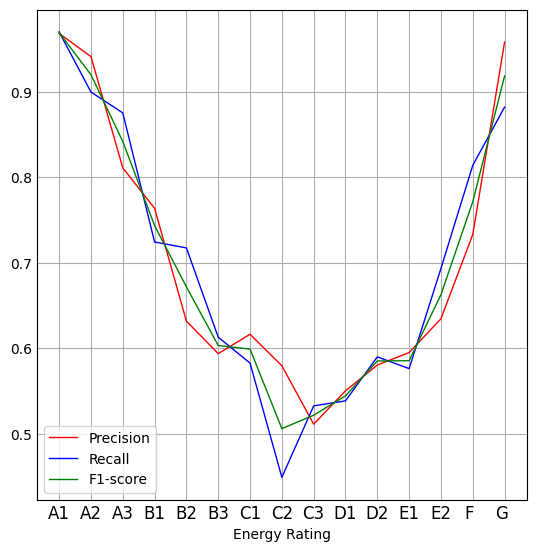

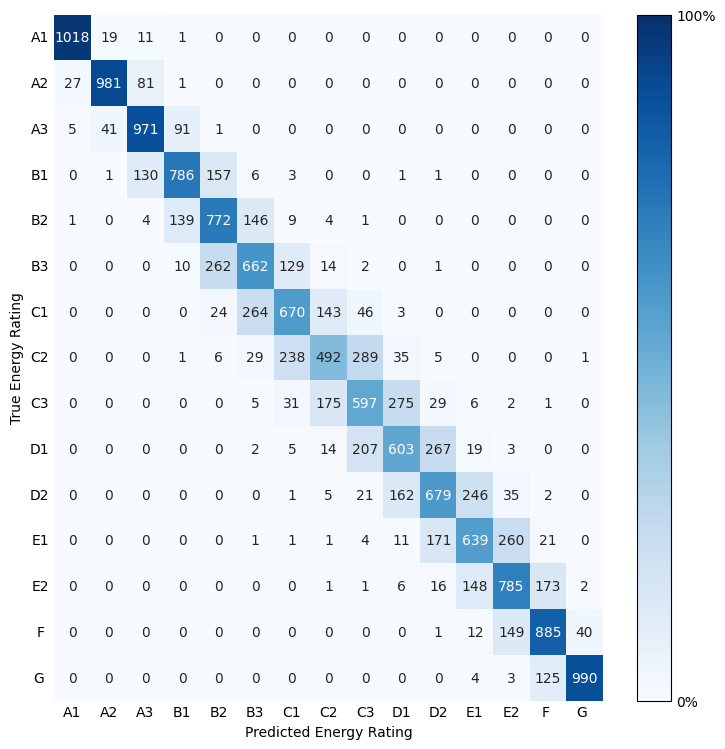

In [76]:
# reports
y_labels = sorted(y_energy_rating_test['EnergyRating'].unique())
x_len = len(y_labels)

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_3, output_dict=True)

plt.style.use('_mpl-gallery')

# get data
x =  np.linspace(0, 1, x_len)
precision = []
recall = []
f1_score = []

for key in y_labels:
  precision.append(report[key]['precision'])
  recall.append(report[key]['recall'])
  f1_score.append(report[key]['f1-score'])

# plot
#cmap = plt.cm.coolwarm
fig_cr, ax_cr = plt.subplots(figsize=(5, 5))
ax_cr.plot(x, precision, color='red', label='Precision', linewidth=1.0)
ax_cr.plot(x, recall, color='blue', label='Recall', linewidth=1.0)
ax_cr.plot(x, f1_score, color='green', label='F1-score', linewidth=1.0)

# Set number of ticks for x-axis
ax_cr.set_xticks(x)
# Set ticks labels for x-axis
ax_cr.set_xticklabels(y_labels, rotation=0, fontsize=12)
ax_cr.set_xlabel('Energy Rating')
ax_cr.set_ylabel('')
plt.legend(loc='best')

plt.show()

# confusion matrix

cf_matrix = confusion_matrix(y_energy_rating_test, y_preds_3)

df_matrix = pd.DataFrame(cf_matrix, index=y_labels, columns=y_labels)
df_matrix_percent =  df_matrix.copy().apply(lambda x: (x/x.sum()), axis=1)

plt.figure(figsize=(7, 7))
#sns_matrix = sns.heatmap(df_matrix_percent, annot=True, cmap='Blues', fmt=f".0f", cbar=False, vmin=0, vmax=100) # annot_kws={"size": 35 / np.sqrt(len(df_matrix))}
sns_matrix = sns.heatmap(df_matrix_percent, annot=df_matrix, fmt=f".0f", cmap="Blues", cbar=False, vmin=0, vmax=1)

sns_matrix.set_yticklabels(sns_matrix.get_yticklabels(), rotation=0)
sns_matrix.set(xlabel="Predicted Energy Rating", ylabel="True Energy Rating")
cbar = sns_matrix.figure.colorbar(sns_matrix.collections[0])
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["0%", "100%"])
plt.show()

### Comparison with HistGradientBoostingClassifier

In [21]:
# Build HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier

# Best parms - copied from above
best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}


pipe4 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('HGBR', HistGradientBoostingClassifier())
            ])

pipe4.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_4 = pipe4.score(X_test, y_energy_rating_test)

y_preds_4 = pipe4.predict(X_test)

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_4)
print(report)

DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

### Explainable Boosting Machine

In [22]:
# Build ExplainableBoostingClassifier

from sklearn.metrics import roc_auc_score

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# Best parms - copied from above
best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}


pipe5 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('HGBR', ExplainableBoostingClassifier())
            ])

pipe5.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_5 = pipe5.score(X_test, y_energy_rating_test)

y_preds_5 = pipe5.predict(X_test)

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_5)
print(report)

# 
#auc = roc_auc_score(y_energy_rating_test, pipe5.predict_proba(X_test)[:, 1])
#print("AUC: {:.3f}".format(auc))

DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerP

c:\Users\jbyrne\AppData\Local\Programs\Python\Python311\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:738: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(
c:\Users\jbyrne\AppData\Local\Programs\Python\Python311\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:995: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerProdComment', 'FirstEnerConsumedComment'

In [23]:
feature_names = X_test.columns

In [24]:
print(feature_names[60])
pipe5

CylinderStat


Pipeline(steps=[('Clean up features',
                 FunctionTransformer(func=<function clean_up_features at 0x0000017E319D0FE0>)),
                ('Drop features', DropFeaturesTransformerSingleton()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('feature_main_heating_fuel',
                                                                   FunctionTransformer(func=<function feature_main_heating_fuel at 0x0000017E325C0180>...
                                                                   MinMaxScaler()),
                                                                  ('Numerical '
                                                                   'Feature '
                                                                   'Logging - '
                                                                   'n 2',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function numerical_features_logging at 0x0000017E5E099760>)),
                                                                  ('num_save_feature_names',
                                                                   SaveFeatureNamesTransformerSingleton())]),
                                                  <numerical_column_selector.NumericalColumnSelector object at 0x0000017E35ADF990>)])),
                ('HGBR', ExplainableBoostingClassifier())])

In [25]:
print(X_test['DeliveredEnergyMainWater'])

39690    6278.145
2410     3406.452
31970    1415.197
62931    2186.191
76384     770.962
           ...   
69743    2678.923
21113    6078.409
35623    1489.019
50875    2020.591
18115    1272.889
Name: DeliveredEnergyMainWater, Length: 16577, dtype: float64


In [26]:
# extract EBM from pipeline and then pass to explain_global
EBM = pipe5['HGBR']
ebm_global = EBM.explain_global(name='HGBR')
show(ebm_global)

<!-- http://127.0.0.1:7001/1640700872656/ -->

In [27]:
EBM_2 = EBM.copy()

In [28]:
#print(EBM_2.feature_names_in_)
feature_names_2 = SaveFeatureNamesTransformerSingleton().get_feature_names()
print(len(feature_names_2))
EBM_2.feature_names_in_ = feature_names_2

SaveFeatureNamesTransformerSingleton - get_feature_names: {'DraftLobby_32_da39a3ee5e6b4b0d3255': ['DraftLobby', 'PermeabilityTest', 'CHBoilerThermostatControlled', 'OBBoilerThermostatControlled', 'OBPumpInsideDwelling', 'WarmAirHeatingSystem', 'UndergroundHeating', 'CylinderStat', 'CombinedCylinder', 'SWHPumpSolarPowered', 'ChargingBasisHeatConsumed', 'FirstWallIsSemiExposed', 'SecondWallIsSemiExposed', 'Tfidfrenewable', 'Tfidfthermal', 'Tfidfhouse', 'Tfidf52', 'Tfidfroof', 'Tfidfon', 'Tfidfpitch', 'Tfidfinsul', 'Tfidfceiling', 'Tfidfdetached', 'Tfidfcavity', 'Tfidf300mm', 'Tfidfmedium', 'Tfidfheating', 'Tfidfoil', 'Tfidfmains', 'Tfidfgas', 'Tfidfsemi', 'Tfidfhigh'], 'Year_of_Construction_102_da39a3ee5e6b4b0d3255': ['Year_of_Construction', 'GroundFloorAreasqm', 'UValueWall', 'UValueRoof', 'UValueFloor', 'UValueWindow', 'UvalueDoor', 'WallArea', 'RoofArea', 'FloorArea', 'WindowArea', 'DoorArea', 'NoStoreys', 'HSMainSystemEfficiency', 'HSEffAdjFactor', 'HSSupplHeatFraction', 'HSSupplSyst

In [74]:
ebm_features_of_interest = [79, 33, 45, 101, 34, 35, 109]
print([feature_names_2[item] for item in ebm_features_of_interest])

['PrimaryEnergyMainSpace', 'GroundFloorAreasqm', 'HSMainSystemEfficiency', 'FirstEnerProdDelivered', 'UValueWall', 'UValueRoof', 'SecondEnerProdDelivered']


In [30]:
ebm_global_2 = EBM_2.explain_global(name='HGBR')
show(ebm_global_2)

<!-- http://127.0.0.1:7001/1640756111888/ -->

In [67]:
# processed test 
X_test_processed_dataset = '/../../data/training/ber-rating-dataset-final-split_0.csv_save_13042024-202408' # balanced dataset

current_folder = os.path.abspath('.')

df_processed = pd.read_table(current_folder + X_test_processed_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="warn")

# replace any spurious characters in feature names
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x))
# replace spaces in features names
df_processed.columns = df_processed.columns.str.strip().str.replace(" ", "").str.replace("[^\w]", "", regex=True)
df_processed.drop('Unnamed0', axis='columns', inplace=True)

print(df_processed.shape)
print(df_processed.head())

print(y_energy_rating_test.shape)


(65400, 134)
   DraftLobby  PermeabilityTest  CHBoilerThermostatControlled  \
0       False             False                          True   
1       False             False                          True   
2       False              True                          True   
3       False             False                          True   
4       False             False                          True   

   OBBoilerThermostatControlled  OBPumpInsideDwelling  WarmAirHeatingSystem  \
0                         False                 False                 False   
1                         False                 False                 False   
2                         False                 False                 False   
3                         False                 False                 False   
4                         False                 False                 False   

   UndergroundHeating  CylinderStat  CombinedCylinder  SWHPumpSolarPowered  \
0                True         False        

In [70]:
df_processed.loc[df['EnergyRating'] == 'C2']

,DraftLobby,PermeabilityTest,CHBoilerThermostatControlled,OBBoilerThermostatControlled,OBPumpInsideDwelling,WarmAirHeatingSystem,UndergroundHeating,CylinderStat,CombinedCylinder,SWHPumpSolarPowered,...,FirstWallArea,FirstWallUValue,FirstWallAgeBandId,FirstWallTypeId,SecondWallArea,SecondWallUValue,SecondWallAgeBandId,SecondWallTypeId,prob_smarea_error_0corr,prob_smarea_error_100corr
4,False,False,True,False,False,False,True,False,False,False,...,0.037705,0.090909,1.000000,0.230769,0.087178,0.114399,0.090909,0.000000,6.023935e-02,0.157148
6,False,True,True,False,False,False,True,False,False,False,...,0.232508,0.057114,1.000000,0.307692,NaN,NaN,NaN,NaN,NaN,NaN
10,False,False,True,False,False,False,False,False,False,False,...,0.157119,0.090909,1.000000,0.692308,NaN,NaN,NaN,NaN,5.006470e-02,0.129209
22,True,True,True,False,False,False,True,False,False,False,...,0.141593,0.060493,1.000000,0.615385,NaN,NaN,NaN,NaN,NaN,NaN
37,False,False,True,False,False,False,False,False,False,False,...,0.094318,0.090909,1.000000,0.230769,NaN,NaN,NaN,NaN,6.023935e-02,0.157148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65343,False,False,True,False,False,False,False,False,False,False,...,0.055625,0.709361,0.181818,0.692308,0.022752,0.286726,0.181818,0.692308,6.023935e-02,0.157148
65345,False,False,False,False,False,False,False,False,False,False,...,0.064787,0.476174,0.272727,0.615385,0.036858,0.286726,0.272727,0.692308,6.379555e-07,0.000000
65356,False,False,False,False,False,False,False,False,False,False,...,0.107951,0.709361,0.272727,0.692308,NaN,NaN,NaN,NaN,6.023935e-02,0.157148
65363,False,False,False,False,False,False,False,False,False,False,...,0.132013,0.709361,0.181818,0.000000,0.231125,0.437383,0.181818,0.000000,6.023935e-02,0.157148


In [72]:
ebm_local_2 = EBM_2.explain_local(df_processed[35:50], y_energy_rating_test[35:50], 0)
show(ebm_local_2)

<!-- http://127.0.0.1:7001/1641030254352/ -->

In [ ]:
# multi_class = ovo, ovr
auc = roc_auc_score(y_energy_rating_test, pipe5.predict_proba(X_test), multi_class='ovo')
print("AUC: {:.3f}".format(auc))